# Make Machine Learning Models Explainable Using SHAP

It is important to explain the output of any machine learning model. 
- SHAP (Shapley Additive Explanations) is a popular technique for this.
- It provides insights into how much each feature in a dataset contributes to a particular prediction, making complex models more understandable and transparent.

SHAP provides an **additive attribution** method, meaning all features' contributions add to the final prediction. This approach makes it possible to see the direct impact of each feature on an outcome in an interpretable way.

SHAP can be applied to **any machine learning model** (like simple linear regression, random forests, XGBOOST, SVMs, etc.) by sampling different combinations of feature values to calculate feature contributions.

## A bit of History
SHAP is based on the Shapley value - originating from the game theory. It was named in honour of Lloyd Shapley. He introduced this concept in 1951 and won the Nobel Memorial Prize in Economic Sciences for this in 2012.

## Step 0: Install and import necessary libraries

In [67]:
#!pip install shap
#!pip install interpret
#!pip install xgboost

In [17]:
import sklearn
import shap
import matplotlib.pyplot as plt
import xgboost

import uts_utility_functions as uts

import warnings
warnings.filterwarnings('ignore')

## Step 1: Load data

While not directly a finance example, the California housing dataset provides an intuitive example and interpretation.

### California Housing Dataset: Detailed Description

The California housing dataset is a widely-used benchmark dataset for regression tasks in machine learning. It contains information on housing prices in California, derived from the 1990 U.S. Census, and is often used for predictive modeling of median housing prices in various districts.

#### Dataset Overview
- **Source**: Derived from the 1990 U.S. Census data.
- **Purpose**: Predict the median house value in a California district based on a variety of features.
- **Number of Instances**: 20,640 observations.
- **Number of Features**: 8 predictive features (plus target variable).

#### Features
1. **MedInc**: Median income in the district (in tens of thousands of dollars).
2. **HouseAge**: Median age of houses in the district (in years).
3. **AveRooms**: Average number of rooms per household in the district.
4. **AveBedrms**: Average number of bedrooms per household in the district.
5. **Population**: Total population of the district.
6. **AveOccup**: Average number of occupants per household in the district.
7. **Latitude**: Latitude of the district's centroid.
8. **Longitude**: Longitude of the district's centroid.

#### Target Variable
- **MedHouseVal**: Median house value for households in the district (in thousands of dollars).

#### Characteristics
- The dataset is real-world and includes features with various distributions (e.g., income and house values are skewed).
- Contains continuous numerical features, with no categorical variables.
- The target variable (**MedHouseVal**) is capped at $500,000 in the dataset, meaning districts with higher median prices are not distinguishable beyond this limit.
  
#### Applications
- **Predictive Modeling**: Used to predict house prices in regression tasks.
- **Exploratory Data Analysis**: Useful for understanding correlations between demographic, geographic, and economic factors.
- **Feature Engineering**: Allows testing of advanced preprocessing techniques for housing market analysis.

#### Limitations
- The dataset is dated (1990 data), and some relationships may not generalize to present-day housing markets.
- The cap on median house values limits the prediction accuracy for high-value districts.
- No inflation adjustment has been applied to monetary values.

**Reference**: The dataset is available in the Scikit-learn library and can be loaded using the `fetch_california_housing()` function.



In [20]:
# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

In [23]:
X100

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12953,3.7813,15.0,5.620058,1.013500,2868.0,2.765670,38.70,-121.28
18537,4.3000,20.0,6.270677,1.137845,981.0,2.458647,36.98,-122.00
13337,3.9107,27.0,5.572816,1.000000,321.0,3.116505,34.04,-117.68
12651,1.6521,36.0,4.068477,1.121606,2460.0,2.904368,38.52,-121.44
19986,2.3152,25.0,5.412844,1.055046,1424.0,3.266055,36.21,-119.32
...,...,...,...,...,...,...,...,...
6232,3.3523,25.0,4.997245,1.112948,1187.0,3.269972,34.07,-117.94
2782,1.2049,17.0,4.337500,1.206250,775.0,2.421875,32.74,-114.66
12601,1.9837,37.0,4.786517,1.014045,902.0,2.533708,38.53,-121.48
2198,7.5000,8.0,6.564885,0.946565,1111.0,2.826972,36.85,-119.88


# Step 2A: Linear Regression model

We fit a linear regression to the dataset for the house pricing prediction.

In [27]:
# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [30]:
uts.display_regression_results(model, X, y);

Linear Regression Results
Dependent Variable: y
Observations: 1000
R-squared: 0.6309
Adjusted R-squared: 0.6280
RMSE: 0.7174
F-statistic: 211.7657 (p-value: 1.1102e-16)

Coefficients:
----------------------------------------------------------------------
Variable         Coefficient    Std Error       t-stat      P-value     
----------------------------------------------------------------------
Intercept           -37.9201       2.9255     -12.9618   0.0000e+00  ***
MedInc                0.4256       0.0185      23.0568   0.0000e+00  ***
HouseAge              0.0103       0.0019       5.3111   1.3457e-07  ***
AveRooms             -0.1161       0.0256      -4.5330   6.5241e-06  ***
AveBedrms             0.6638       0.1180       5.6277   2.3768e-08  ***
Population            0.0000       0.0000       1.3100   1.9050e-01     
AveOccup             -0.2610       0.0267      -9.7560   0.0000e+00  ***
Latitude             -0.4673       0.0318     -14.6967   0.0000e+00  ***
Longitude        

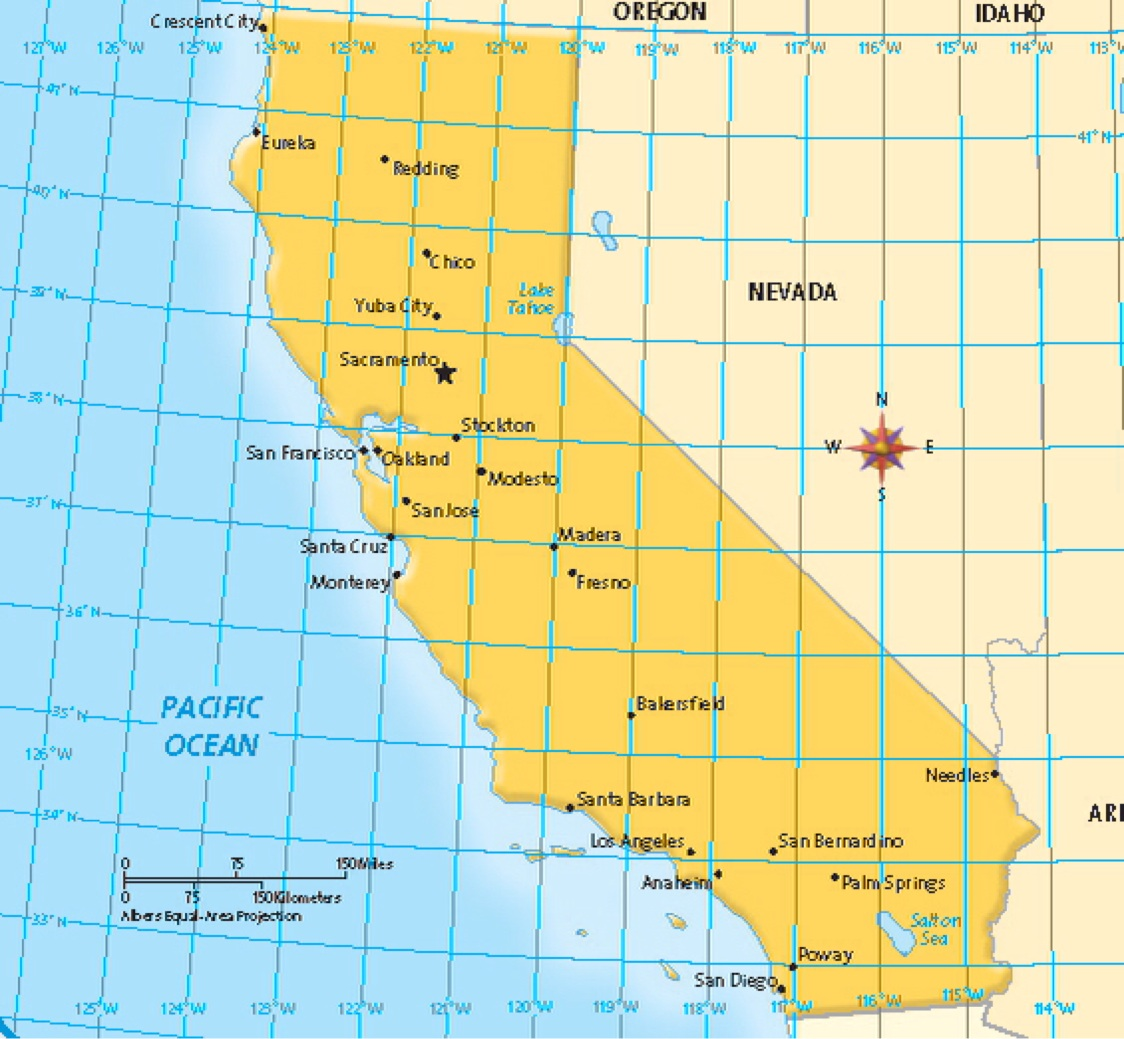

In [100]:
from IPython.display import Image
Image("figs/California_map.jpg")

### Linear Regression: Explanation and Interpretation

Linear regression is a simple and interpretable model that predicts the dependent variable $$y$$ as a linear combination of explanatory variables (features). The general model equation is: 

$$ y = \beta_0 + \beta_1 \cdot \text{MedInc} + \beta_2 \cdot \text{HouseAge} + \beta_3 \cdot \text{AveRooms} + \beta_4 \cdot \text{AveBedrms} + \beta_5 \cdot \text{Population} + \beta_6 \cdot \text{AveOccup} + \beta_7 \cdot \text{Latitude} + \beta_8 \cdot \text{Longitude} + \epsilon $$

where:
- $y$: Dependent variable (Median house value in this context).
- $\beta_0$: Intercept (baseline value of $y$ when all features are zero).
- $\beta_i$: Coefficients representing the effect of each feature on $y$.
- $\epsilon$: Error term accounting for variability not explained by the model.

Using the estimated coefficients from the regression, the equation becomes:

$$ \hat{y} = -37.9201 + 0.4256 \cdot \text{MedInc} + 0.0103 \cdot \text{HouseAge} - 0.1161 \cdot \text{AveRooms} + 0.6638 \cdot \text{AveBedrms} + 0.0000 \cdot \text{Population} - 0.2610 \cdot \text{AveOccup} - 0.4673 \cdot \text{Latitude} - 0.4627 \cdot \text{Longitude} $$

### Interpretation of Coefficients

1. **Intercept ($\beta_0 = -37.9201$)**: 
   - When all features are zero, the predicted median house value is \(-37.92\) (not meaningful in this context but serves as a baseline).

2. **MedInc ($\beta_1 = 0.4256 $)**: 
   - For every one-unit increase in median income (in tens of thousands of dollars), the median house value increases by approximately \( 0.4256 \) (thousands of dollars), holding other factors constant.

3. **HouseAge ($\beta_2 = 0.0103$)**: 
   - For every additional year in the median house age, the median house value increases by \( 0.0103 \) (thousands of dollars), holding other factors constant.

4. **AveRooms ($ \beta_3 = -0.1161 $)**:
   - For every additional average room per household, the median house value decreases by \( 0.1161 \) (thousands of dollars), holding other factors constant. This might indicate diminishing returns or collinearity effects.

5. **AveBedrms ($ \beta_4 = 0.6638 $)**:
   - For every additional average bedroom per household, the median house value increases by \( 0.6638 \) (thousands of dollars), holding other factors constant.

6. **Population ($ \beta_5 = 0.0000 $)**:
   - The coefficient is essentially zero, indicating no significant relationship between population and median house value.

7. **AveOccup ($ \beta_6 = -0.2610 $)**:
   - For every additional average occupant per household, the median house value decreases by \( 0.2610 \) (thousands of dollars), holding other factors constant.

8. **Latitude ($ \beta_7 = -0.4673 $)**:
   - For every one-degree increase in latitude (moving north), the median house value decreases by \( 0.4673 \) (thousands of dollars), holding other factors constant. This might reflect lower housing prices in northern areas compared to southern California, where regions like Los Angeles and San Diego have higher median house values.

9. **Longitude ($ \beta_8 = -0.4627 $)**:
   - For every one-degree increase in longitude (that is a decrease in a negative longitude value, meaning moving west), the median house value decreases by \( 0.4627 \) (thousands of dollars), holding other factors constant. This suggests that housing prices tend to be higher along the coast (east), while inland areas (west) are generally less expensive. 

---

### Using the Model for Predictions

The model can be used to predict the median house value ($ \hat{y}$) for specific characteristics. For example, substituting the following values into the equation:
- $ \text{MedInc} = 5 $
- $ \text{HouseAge} = 20 $
- $ \text{AveRooms} = 6 $
- $ \text{AveBedrms} = 1$
- $ \text{Population} = 1000 $
- $ \text{AveOccup} = 3 $
- $ \text{Latitude} = 34 $
- $ \text{Longitude} = -118 $

the predicted house value would be:

$$ \hat{y} = -37.9201 + (0.4256 \cdot 5) + (0.0103 \cdot 20) - (0.1161 \cdot 6) + (0.6638 \cdot 1) + (0.0000 \cdot 1000) - (0.2610 \cdot 3) - (0.4673 \cdot 34) - (0.4627 \cdot (-118)) $$

**Key Takeaways**
- Linear regression provides a simple, interpretable model for predicting housing prices.
- Coefficients quantify the relationships between features and the target variable, offering actionable insights.
- Substituting specific values allows us to predict the median house value for any given set of characteristics, providing a practical, average-based estimate.

### Partial Dependence plots

To understand a feature's importance in a model, it is necessary to understand both **how changing that feature impacts the model's output**, and also **the distribution of that feature's values**. To visualize this for a linear model we can build a classical partial dependence plot and show the distribution of feature values as a histogram on the x-axis:

The partial dependence plot below illustrates how the feature `MedInc` affects the model's predictions, showing its impact on the prediction while averaging over other features.
- The $Y$-axis displays $E[f(x)|X]$.
- That is, the average (or expected $E[\;]$) value of target variable $f(x)$ (since the target variable is a function of x's), conditional (symbol "$|$") on the values of $X$ variable.
- Specifically, the $Y$-axis shows the expected (average) home values, written as $E[MedHouseVal|MedInc]$ (read as "expected Median House Value given the level of MedianIncome").
- This means we're looking at how median house values typically change for each level of median income (while keeping all other X variables constant).

Since `ice = False`, it only shows the **average trend** without individual conditional expectation (ICE) lines. This plot highlights the general relationship between `MedInc` and the model's predictions.

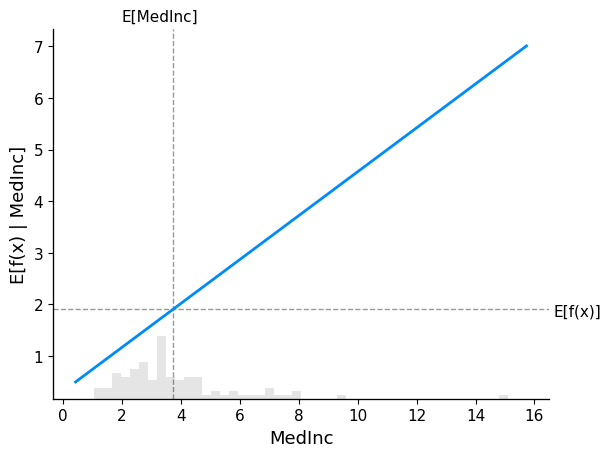

In [35]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, 
    ice=False,
    model_expected_value=True,
    feature_expected_value=True, 
    show=False
)
#plt.savefig('partial_dependence_plot_lr_MedInc.png', format='png', dpi=600, bbox_inches='tight') # [optional] Save the plot to file
plt.show()

**Partial dependence plots** (graph interpretation): 
- The gray horizontal line in the plot above represents the expected value of the model when applied to the California housing dataset.
- The vertical gray line represents the average value of the median income feature.
- Note that the blue partial dependence plot line (which is the average value of the model output when we fix the median income feature to a given value) always passes through the intersection of the two gray expected value lines.
- We can consider this intersection point as the *center* of the partial dependence plot with respect to the data distribution.
- The impact of this centering will become clear when we turn to Shapley values next.

**Partial dependence plots** with ICE (`ice=True`):

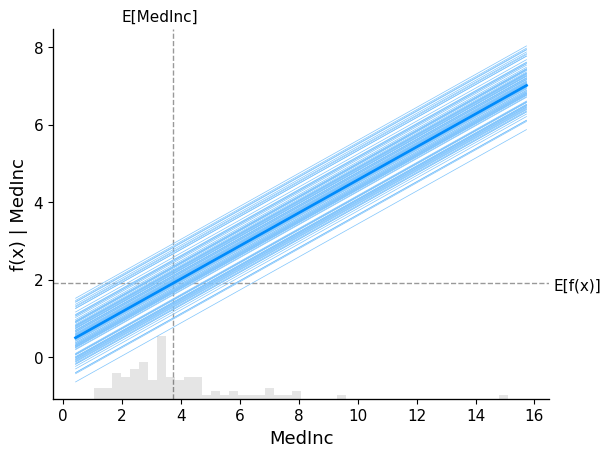

In [39]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, 
    ice=True,
    model_expected_value=True,
    feature_expected_value=True, 
    show=False
)
plt.show()

Let me explain the `ice=True/False` parameter in SHAP's partial dependence plot:
- When `ice=True`, it shows Individual Conditional Expectation (ICE) lines in addition to the partial dependence plot. 

Here's what this means intuitively:

Without ICE (`ice=False`):
- Shows only the average effect of `MedInc` on house prices
- You see one line representing the average relationship
- Easier to read but hides individual variations

With ICE (`ice=True`):
- Shows both the average effect AND individual predictions
- Each thin blue line represents how the prediction would change for a single house if we varied only its `MedInc` value
- The bold line is still the average (like before)

Helps you see:
- How much variation exists between individual cases
- If the relationship is consistent across different houses
- Potential interactions with other features (shown by different slopes in ICE lines)

Think of it like this:
- Without ICE: "On average, houses with higher `MedInc` cost more"
- With ICE: "Here's how EACH house's price would change if we changed its `MedInc`, and here's the average pattern"

It's similar to looking at both individual data points and a trend line in a scatter plot - you get to see both the general pattern and the individual variations.

### Explore a specific instance

You can always explore in detail a specific instance (a single observation of characteristics on a particular house in the data):


In [45]:
# Pick several different rows and compare the outputs:
# 1) the specific house characteristics (values of data points from dataset)
# 2) the predicted house price based on these data points as well as HOW this predicted price was calculated using individual contributions

sample_ind = 25 # this is a house and its characteristics in the specific row of the sample database
display(X100.iloc[sample_ind])

ex = shap.KernelExplainer(model.predict, X100)
shap_values = ex.shap_values(X100.iloc[sample_ind])
shap.force_plot(ex.expected_value, shap_values, X100.iloc[sample_ind])

MedInc           2.067400
HouseAge        14.000000
AveRooms         5.225367
AveBedrms        1.297694
Population    2517.000000
AveOccup         2.638365
Latitude        34.200000
Longitude     -116.380000
Name: 13903, dtype: float64

In [51]:
sample_ind = 20 # try a different house and note its new characteristics below
display(X100.iloc[sample_ind])

ex = shap.KernelExplainer(model.predict, X100)
shap_values = ex.shap_values(X100.iloc[sample_ind])
shap.force_plot(ex.expected_value, shap_values, X100.iloc[sample_ind])

MedInc           6.066300
HouseAge        30.000000
AveRooms         6.862539
AveBedrms        1.039874
Population    3124.000000
AveOccup         3.278069
Latitude        33.970000
Longitude     -118.000000
Name: 6981, dtype: float64

The code snippet below creates a partial dependence plot for `MedInc` with the addition of SHAP values for a specific instance (e.g., at index 20 in X100), providing both a global and local explanation.

The partial dependence plot still shows the global average relationship betwee` "MedI`c" and the mod'l’s predictions, just like in the previous figure.

The line `shap_values=shap_values[sample_ind : sample_ind + 1, :]` overlays the SHAP values for a single instance (here, sample 20), indicating how `MedInc` specifically impacts that instance's prediction. This helps in comparing the instance's behaviour against the global trend.

The SHAP values for the chosen sample allow us to see if `MedInc` has an atypical influence for that instance compared to the average. If `MedInc` has a stronger or weaker impact than usual, this will be evident in the SHAP overlay.

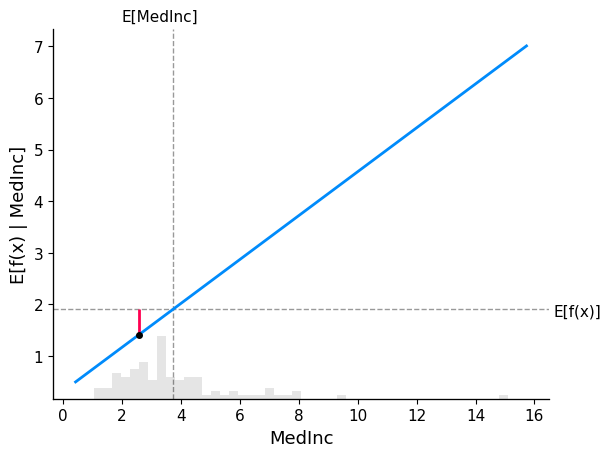

In [55]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
shap.partial_dependence_plot(
    "MedInc", model.predict, X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
    show = False
)
#plt.savefig("partial_dependence_plot_lr.png", format="png", bbox_inches="tight") # [optional] Save the plot to file
plt.show()

The below is a scatter plot of the SHAP values for the feature `MedInc`. It provides insights into how this feature affects the model's predictions across different samples in the dataset.

Each SHAP value(Y-axis) represents the magnitude and direction of `MedInc`'s contribution to a model's prediction for a particular instance. A Positive SHAP values mean that `MedInc` increases the prediction, while negative SHAP values mean it decreases the prediction.

The x-axis on the plot shows the actual values of `MedInc` across different samples. This shows how changes in `MedInc` values influence its SHAP value and, consequently, the model's prediction.

A positive correlation between `MedInc` and SHAP values means higher values of `MedInc` tend to increase predictions. A non-linear or scattered pattern might indicate complex interactions between `MedInc` and other features, affecting the prediction in various ways.

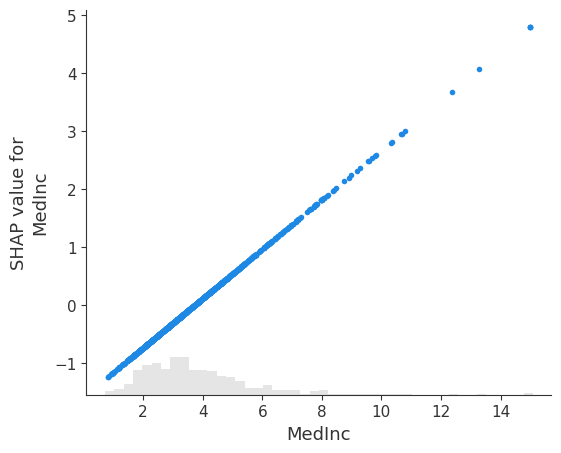

In [58]:
shap.plots.scatter(shap_values[:, "MedInc"], show =False)
#plt.savefig("scatter_plot_lr_MedInc.png", format="png", bbox_inches="tight") # [optional] Save the plot to file
plt.show()

The below **waterfall plot** explains how the SHAP values for a single instance (specified by `sample_ind`, here 20) contribute to its prediction in the model.

Here, the top014 influential features have been plotted to visualize the main contributors.

The plot starts with the base val`ue (shap_values.base_va`lues), which is the average model prediction over the dataset. Each fea'ure’s SHAP value (positive or negative) is then added or subtracted from the base value, moving toward the specific prediction for the selected instance. Features with positive SHAP values increase the prediction, while those with negative SHAP values decrease it.

The waterfall plot is a powerful tool for understanding local interpretability — it shows precisely how each feature affects the'model’s prediction for a single instance

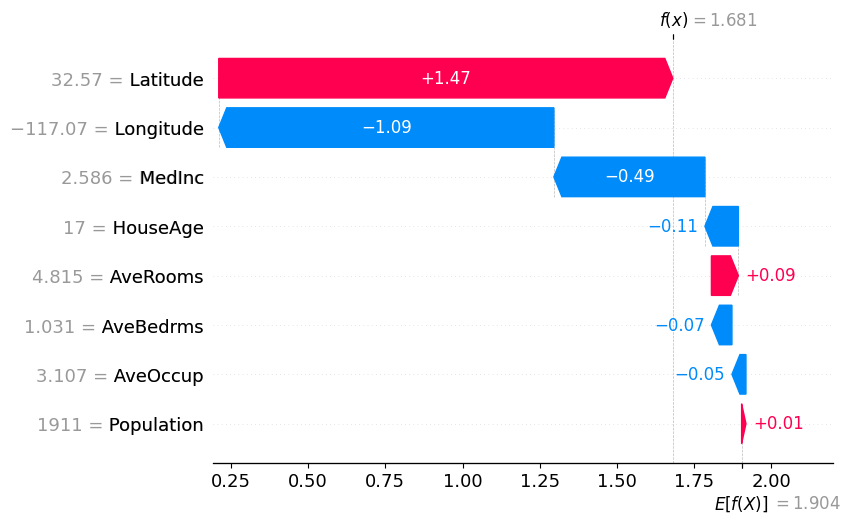

In [63]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=10,show = False)
# plt.savefig("waterfall_plot_lr.png", format="png", bbox_inches="tight")  # [optional] Save the plot to file
plt.show()

# XGBOOST

## Introduction to SHAP for XGBoost Models

After exploring SHAP (SHapley Additive exPlanations) for linear regression, we now extend this analysis to the more complex and non-linear **XGBoost** (Extreme Gradient Boosting) model. XGBoost is a powerful machine learning algorithm widely used for its ability to handle non-linear relationships, interactions between features, and large datasets efficiently. However, these advantages often come at the cost of reduced interpretability compared to simpler models like linear regression.

### Why Use SHAP for XGBoost?
1. **Non-linear and Complex Relationships**:
   - Unlike linear regression, XGBoost captures intricate patterns and interactions in the data, making it a "black box" model. SHAP provides insights into these complexities by explaining the contribution of each feature to the model's predictions.

2. **Feature Importance**:
   - SHAP helps rank features based on their importance to the model, allowing us to understand which variables are driving predictions.

3. **Individual-Level Explanations**:
   - SHAP goes beyond global feature importance and explains the contribution of features for each individual prediction. This is critical in finance, where model transparency is required for trust and compliance.

4. **Interactive Visualisations**:
   - SHAP offers intuitive visual tools such as dependence plots, summary plots, and force plots, making it easier to communicate findings and explain model decisions tore these concepts in depth.


In [67]:
# train XGBoost model
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

In [70]:
# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

In [73]:
sample_ind = 20 # this is a house and its characteristics in the specific row of the sample database
display(X100.iloc[sample_ind])
print('\n') # print empty line

# Linear Regression SHAP plot
# Recall SHAP explainability for the price of a house at row = 20 when we did linear regression:
print(f'SHAP for linear regression at sample_id={sample_ind}')
ex = shap.KernelExplainer(model.predict, X100)
shap_values = ex.shap_values(X100.iloc[sample_ind])
display(shap.force_plot(ex.expected_value, shap_values, X100.iloc[sample_ind]))

# XGBOOST SHAP plot
# We can do the same for XGBOOST:
print(f'SHAP for XGBOOST regression at sample_id={sample_ind}')
shap_values = explainer_xgb.shap_values(X100.iloc[sample_ind])
display(shap.force_plot(explainer_xgb.expected_value, shap_values, X100.iloc[sample_ind]))

MedInc           6.066300
HouseAge        30.000000
AveRooms         6.862539
AveBedrms        1.039874
Population    3124.000000
AveOccup         3.278069
Latitude        33.970000
Longitude     -118.000000
Name: 6981, dtype: float64



SHAP for linear regression at sample_id=20


SHAP for XGBOOST regression at sample_id=20


**Comparing Predictions**: Linear Regression vs XGBoost
- Compare the SHAP plots for both models and observe how each feature affects the predicted price $f(x)$.
- Now, note that the feature values (the house price characteristics) are identical — it is the same house, after all.
- However, the two models, linear regression and XGBoost, give different predictions for the house given these characteristics.

### Key Points for Comparison:
1. **Linear Regression**:
   - A simple, interpretable model assumes a linear relationship between features and the target (house price).
   - The contribution of each feature to the predicted price is consistent across observations, as shown in the SHAP plot for linear regression. Features with positive coefficients increase the predicted price, while those with negative coefficients decrease it.

2. **XGBoost**:
   - A non-linear model captures complex interactions and non-linear effects between features and the target.
   - In the SHAP plot for XGBoost, the contribution of a feature to the predicted price varies based on its value and the values of other features. This highlights the model's ability to adapt to nuanced relationships in the data.


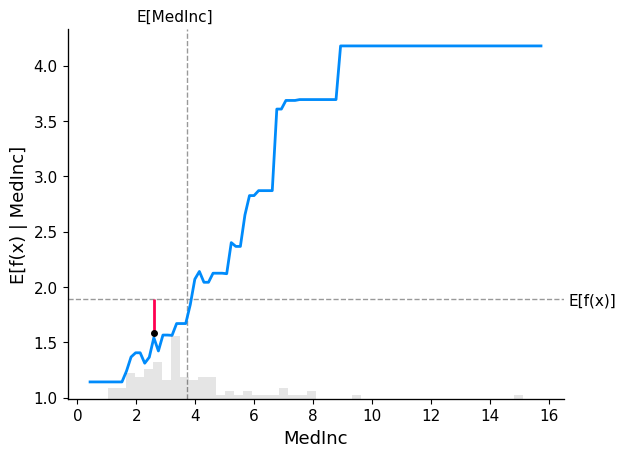

In [83]:
# make a standard partial dependence plot with a single SHAP value overlaid
shap.partial_dependence_plot(
    "MedInc", model_xgb.predict, X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)
# plt.savefig("partial_dependence_plot_with_shap_XGBoost.png", format="png", bbox_inches="tight") # [optional] Save the plot to file
plt.show()

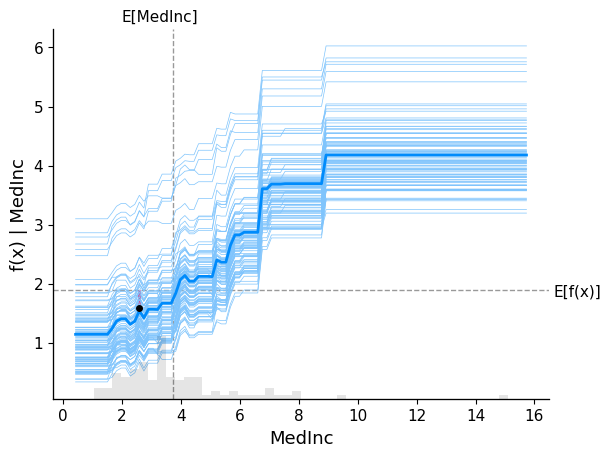

In [86]:
# make a standard partial dependence plot with a single SHAP value overlaid
shap.partial_dependence_plot(
    "MedInc", model_xgb.predict, X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=True,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)
# plt.savefig("partial_dependence_plot_with_shap_XGBoost.png", format="png", bbox_inches="tight") # [optional] Save the plot to file
plt.show()

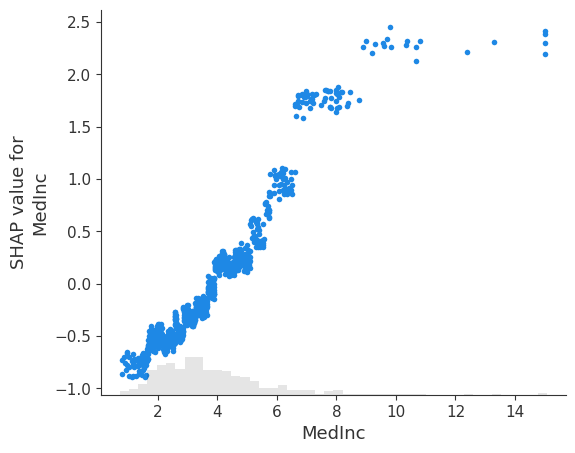

In [89]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"], show = False)
#plt.savefig("scatter_plot_xgb_MedInc.png", format="png", bbox_inches="tight") # [optional] Save the plot to file
plt.show()

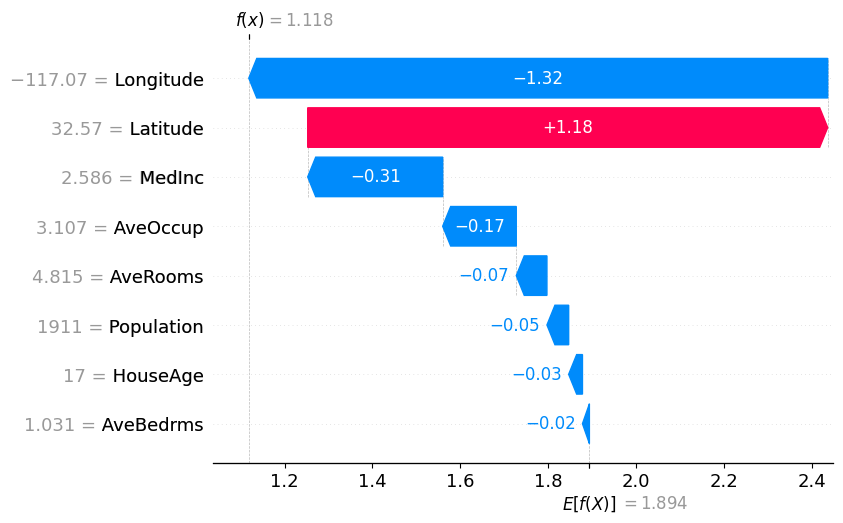

In [92]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_xgb[sample_ind], show =False)
# plt.savefig("waterfall_plot_XGB.png", format="png", bbox_inches="tight") # [optional] Save the plot to file
plt.show()